In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [89]:
class PositionalEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input size updated to 10: original 2 + (sin, cos values for orders 1 to 4) * 2
        self.fc1 = nn.Linear(18, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 7)
        self.ac1 = nn.LeakyReLU()
        self.norm1 = nn.BatchNorm1d(256)
        self.norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x[:, 0] *= torch.pi / 180
        x[:, 1] *= torch.pi / 360
        # Compute sine and cosine for orders 1 to 4
        features = [x]  # Start with the original input
        for order in range(1, 5):
            features.append(torch.sin(order * x))  # sin(nx)
            features.append(torch.cos(order * x))  # cos(nx)

        # Concatenate all features along the last dimension
        x = torch.cat(features, dim=1)

        # Forward pass through the network
        x = self.norm1(self.ac1(self.fc1(x)))
        x = self.norm2(self.ac1(self.fc2(x)))
        x = self.fc3(x)
        return x, F.softmax(x, dim=1)[:, :6]


k = 10
models = [PositionalEncoder() for _ in range(k)]
for i, model in enumerate(models):
    model.load_state_dict(
        torch.load(
            f"./ckpts/20241207002727/model_{i}.pt",
            weights_only=False,
            map_location=torch.device("cpu"),
        )
    )
    model.to("mps")
    model.eval()

In [90]:
atwts = pd.read_csv("./data_constants/atomicweight.txt", sep="\t", header=None)
atwts.columns = ["atno", "sym", "atwt"]
atwts.set_index("sym", inplace=True)
atwts.atwt

elements = ["mg", "al", "si", "ca", "ti", "fe", "o"]

ele_wts = atwts.loc[elements].atwt

oxides = ["mgo", "al2o3", "sio2", "cao", "tio2", "feo"]

owts = {
    "mgo": ele_wts["o"] / (ele_wts["mg"] + ele_wts["o"]),
    "al2o3": ele_wts["o"] * 3 / (2 * ele_wts["al"] + 3 * ele_wts["o"]),
    "sio2": ele_wts["o"] * 2 / (ele_wts["si"] + 2 * ele_wts["o"]),
    "cao": ele_wts["o"] / (ele_wts["ca"] + ele_wts["o"]),
    "tio2": ele_wts["o"] * 2 / (ele_wts["ti"] + 2 * ele_wts["o"]),
    "feo": ele_wts["o"] / (ele_wts["fe"] + ele_wts["o"]),
}

orelwt = list(owts.values())
orelwt = torch.tensor(orelwt, dtype=torch.float32).to("mps")


def position_to_elements(input):
    input = input.clone()
    outputs = torch.stack([model(input)[1] for model in models])
    oxides = torch.mean(outputs, axis=0)
    ox_contrib = oxides * orelwt
    elems = oxides - ox_contrib
    oxygen = torch.sum(ox_contrib, axis=1)

    return torch.cat((elems, oxygen.unsqueeze(1)), dim=1)


def position_to_elements_model(model, input):
    input = input.clone()
    oxides = model(input)[1]
    ox_contrib = oxides * orelwt
    elems = oxides - ox_contrib
    oxygen = torch.sum(ox_contrib, axis=1)

    return torch.cat((elems, oxygen.unsqueeze(1)), dim=1)

In [91]:
class ValidationDataset(Dataset):
    def __init__(self, lat, lon):
        self.data = np.array([(lt, ln) for lt in lat for ln in lon])
        print(self.data)
        self.lats = lat.shape[0]
        self.lons = lon.shape[0]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [ ]:
lat = np.arange(-90, 90, 1)
lon = np.arange(-180, 180, 1)
valid_dl = DataLoader(ValidationDataset(lat, lon), batch_size=1024, shuffle=True)

map = np.zeros((lat.shape[0], lon.shape[0], 7))
with torch.no_grad():
    for input in tqdm(valid_dl):
        input = input.to("mps")
        output = position_to_elements(input)
        input = input.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        map[(input[:, 0]).astype(int) + 90, (input[:, 1]).astype(int) + 180] = output

[[ -90 -180]
 [ -90 -179]
 [ -90 -178]
 ...
 [  89  177]
 [  89  178]
 [  89  179]]


  6%|▋         | 4/64 [00:00<00:01, 37.67it/s]

[[ 59. -11.]
 [-37. 122.]
 [-20.   1.]
 ...
 [ 14.  34.]
 [-22. -20.]
 [-65. -73.]]
[[ 31. -68.]
 [ 15. 123.]
 [ 55.  -2.]
 ...
 [-67.  47.]
 [  9. 110.]
 [ 49.  -4.]]
[[ -42.  152.]
 [  63. -118.]
 [  -3.  -15.]
 ...
 [  79.  -16.]
 [  58. -114.]
 [ -82.  -71.]]
[[ 73.  74.]
 [ 48. -34.]
 [-14. -29.]
 ...
 [ 73. 157.]
 [-33.  76.]
 [-71.  60.]]
[[  12.  122.]
 [  30.  121.]
 [  86. -108.]
 ...
 [ -40.   55.]
 [ -40.  -87.]
 [ -78.   91.]]
[[ -34.  -87.]
 [  42.   19.]
 [  64.  -11.]
 ...
 [  13.   39.]
 [  70. -112.]
 [ -54.  -28.]]
[[ -18.  -29.]
 [ -12.  176.]
 [  50.  -84.]
 ...
 [  53. -121.]
 [ -86.   13.]
 [   3.   80.]]
[[ 11.  18.]
 [-27.  60.]
 [-83.  61.]
 ...
 [ 49. -84.]
 [ 20. 159.]
 [-23. -73.]]


 16%|█▌        | 10/64 [00:00<00:01, 45.62it/s]

[[  58.  -82.]
 [ -70.  -50.]
 [   0.  -44.]
 ...
 [ -76. -169.]
 [  -7.   26.]
 [   4. -138.]]
[[ -38.  157.]
 [  80.   40.]
 [ -25.  134.]
 ...
 [  64. -131.]
 [ -59.   59.]
 [ -75.   62.]]


 23%|██▎       | 15/64 [00:00<00:01, 46.65it/s]

[[ -53.  -99.]
 [  25.  -21.]
 [  66.   -9.]
 ...
 [ -12.  109.]
 [ -25.  -44.]
 [ -32. -156.]]
[[  66.  -59.]
 [  73.  120.]
 [  63.   28.]
 ...
 [  23.  -44.]
 [  53.  132.]
 [  79. -137.]]
[[  26.  -96.]
 [  46.   39.]
 [  29.  140.]
 ...
 [ -58.  175.]
 [  -4. -165.]
 [ -34.  -49.]]
[[ 14. -66.]
 [-22. -78.]
 [-80.  13.]
 ...
 [-20.  78.]
 [ 23. -71.]
 [ -7. -35.]]
[[-78. -92.]
 [ 31. -96.]
 [ 43. 174.]
 ...
 [ 33.  30.]
 [-18. -47.]
 [-54. -65.]]
[[ -46.  136.]
 [ -64.  -61.]
 [ -66.  -86.]
 ...
 [  25. -129.]
 [  28. -122.]
 [  65. -124.]]
[[  17.  -39.]
 [  81. -122.]
 [ -74.  -31.]
 ...
 [  81.  -72.]
 [ -21.   94.]
 [  38.  -36.]]
[[  81.   86.]
 [ -33. -135.]
 [ -88.   35.]
 ...
 [ -78.  -24.]
 [ -38.  126.]
 [  47.   27.]]


 33%|███▎      | 21/64 [00:00<00:00, 48.58it/s]

[[ -66.  108.]
 [ -40.   22.]
 [ -40.  -88.]
 ...
 [  73.   87.]
 [  87. -169.]
 [  82. -119.]]
[[  28.  -37.]
 [ -51. -102.]
 [  37.  -91.]
 ...
 [ -76.  163.]
 [ -38.   -6.]
 [  39. -153.]]
[[ -27.   98.]
 [ -11.  -78.]
 [  45. -151.]
 ...
 [  89. -137.]
 [ -48.  173.]
 [  66.   12.]]


 42%|████▏     | 27/64 [00:00<00:00, 49.33it/s]

[[ -69. -155.]
 [  29. -119.]
 [ -50. -116.]
 ...
 [   8.  -14.]
 [ -87.   59.]
 [ -18.  -25.]]
[[ -67.  157.]
 [  86.  154.]
 [  81. -132.]
 ...
 [ -18.  102.]
 [  22. -123.]
 [  -4. -157.]]
[[ -71.   18.]
 [ -82. -114.]
 [ -54.   71.]
 ...
 [  10.  -78.]
 [   1.  168.]
 [ -84.   48.]]
[[ -36. -121.]
 [  35.   46.]
 [ -78. -110.]
 ...
 [  11.   26.]
 [ -15.   61.]
 [  77.  -41.]]
[[  63.  -30.]
 [  13.   74.]
 [  56. -120.]
 ...
 [ -43.  -14.]
 [ -89.   41.]
 [ -20.  -94.]]
[[ -20. -169.]
 [  55.   94.]
 [  50. -103.]
 ...
 [   0.  152.]
 [ -38.  -85.]
 [ -51.   19.]]
[[  43.  155.]
 [  52. -154.]
 [ -63.  119.]
 ...
 [  65.  -94.]
 [ -49.   63.]
 [   5.  -19.]]
[[ -68. -178.]
 [ -18.   84.]
 [  76.  -43.]
 ...
 [   7.  -84.]
 [  54.   31.]
 [ -90. -101.]]
[[ -33. -134.]
 [  11.  175.]
 [ -36. -158.]
 ...
 [  82.    8.]
 [  46.   52.]
 [ -46. -120.]]
[[  30.  -79.]
 [  37.  -26.]
 [  46. -171.]
 ...
 [   1.  -72.]
 [ -53. -141.]
 [ -26.   77.]]


 50%|█████     | 32/64 [00:00<00:00, 41.59it/s]

[[ -22.  112.]
 [  78. -138.]
 [ -27.   26.]
 ...
 [ -76. -121.]
 [ -64.   26.]
 [ -13.   66.]]
[[ -84.  116.]
 [  30.  -76.]
 [  -6.  -54.]
 ...
 [ -61.  129.]
 [ -59. -100.]
 [  76.   20.]]
[[ -81.   42.]
 [  63.  -35.]
 [  51.   66.]
 ...
 [  61.  117.]
 [ -52. -109.]
 [ -48.   44.]]
[[ -86.  -42.]
 [  13. -119.]
 [ -76.    1.]
 ...
 [  30.   23.]
 [  89. -114.]
 [  -9.   42.]]
[[ -19. -166.]
 [  29.  129.]
 [  55.   96.]
 ...
 [ -43.  -68.]
 [ -27. -171.]
 [  85. -153.]]


 58%|█████▊    | 37/64 [00:00<00:00, 43.10it/s]

[[  -4. -142.]
 [  61.   35.]
 [ -24.  142.]
 ...
 [   2.  -14.]
 [  46. -136.]
 [  85. -167.]]
[[  22.  -55.]
 [ -24.   24.]
 [ -57. -140.]
 ...
 [  31.  141.]
 [ -74.  123.]
 [ -24.   52.]]
[[ -33.  -26.]
 [ -52.  -60.]
 [  61.  171.]
 ...
 [ -40.  179.]
 [ -84. -180.]
 [  79.  -29.]]
[[  39.   26.]
 [ -84.  -12.]
 [  -5.   77.]
 ...
 [  42.  -11.]
 [  84. -102.]
 [  76.  120.]]
[[ 11. 142.]
 [-75.  85.]
 [ 81. -20.]
 ...
 [ 71. -74.]
 [-51.  -4.]
 [ 11. -23.]]


 66%|██████▌   | 42/64 [00:00<00:00, 43.73it/s]

[[  62. -138.]
 [  -8.  165.]
 [  25.   82.]
 ...
 [  61.   53.]
 [   9.   64.]
 [  80.    5.]]
[[ -70.  145.]
 [ -75.  -54.]
 [  19.  -92.]
 ...
 [  74. -120.]
 [  83.  -95.]
 [  -1. -132.]]
[[ -58.  -74.]
 [ -16. -142.]
 [  72.  -43.]
 ...
 [  86. -139.]
 [  80.  158.]
 [  57. -140.]]
[[  87.   -5.]
 [  -3.  137.]
 [  75.  131.]
 ...
 [ -61.  155.]
 [   9.  -12.]
 [ -39. -164.]]
[[ -14. -111.]
 [  -6.   79.]
 [ -51. -168.]
 ...
 [ -17.   10.]
 [  -2.  -12.]
 [  44.   34.]]


 73%|███████▎  | 47/64 [00:01<00:00, 45.26it/s]

[[  18.   -4.]
 [  51.  -85.]
 [  85.   97.]
 ...
 [  42. -130.]
 [   4.  -76.]
 [ -13.   52.]]
[[ -82.  176.]
 [  30.   -2.]
 [ -29. -169.]
 ...
 [  30.   10.]
 [   7.   40.]
 [ -57.  145.]]
[[ 59.  72.]
 [-77. -89.]
 [-43. -33.]
 ...
 [ 77. 130.]
 [ 28.  34.]
 [-87. -64.]]
[[  -1.    6.]
 [  57.  -84.]
 [   9. -115.]
 ...
 [  20.   59.]
 [   2.  -45.]
 [  15.  108.]]
[[  2.  33.]
 [-13. 113.]
 [-45. 148.]
 ...
 [ 53. -53.]
 [-18. 161.]
 [ 48. -26.]]
[[ -69.  149.]
 [   2. -168.]
 [  76. -123.]
 ...
 [ -24.  102.]
 [  71.   16.]
 [  28.  173.]]


 83%|████████▎ | 53/64 [00:01<00:00, 46.58it/s]

[[ 53.  30.]
 [-69. -33.]
 [ 79.  38.]
 ...
 [ 75. -45.]
 [-17. -81.]
 [ 65.  78.]]
[[ -52.  151.]
 [ -57.  -98.]
 [  39.  164.]
 ...
 [  27. -126.]
 [ -64.  169.]
 [  56.   62.]]
[[ -68. -137.]
 [ -34.  -85.]
 [  37.  -70.]
 ...
 [ -71.  164.]
 [ -20.  -90.]
 [  50.  -33.]]
[[  50.  -31.]
 [   8.  -15.]
 [ -66. -146.]
 ...
 [ -64.  -23.]
 [ -41.  -44.]
 [ -64. -161.]]


 91%|█████████ | 58/64 [00:01<00:00, 47.41it/s]

[[  51.   -7.]
 [  14.   -8.]
 [ -18.  -30.]
 ...
 [ -27.  159.]
 [  19.  -65.]
 [ -68. -116.]]
[[  34.   41.]
 [ -10.   60.]
 [ -15.  -27.]
 ...
 [ -25.  107.]
 [ -52.  -77.]
 [  23. -141.]]
[[  56.  -51.]
 [ -32. -158.]
 [  11. -167.]
 ...
 [ -86.  151.]
 [  -3.  139.]
 [ -69.  170.]]
[[  88.  171.]
 [   3.  166.]
 [ -42.    8.]
 ...
 [  18.   20.]
 [ -64.  167.]
 [  13. -127.]]
[[  58.  123.]
 [ -18.   35.]
 [  38. -180.]
 ...
 [ -48. -162.]
 [ -28.   86.]
 [  64.   50.]]
[[  70. -125.]
 [  53.  -36.]
 [  18.  -72.]
 ...
 [  82.  -62.]
 [  30.  175.]
 [ -68.  104.]]
[[  56.  -49.]
 [  33.    6.]
 [ -38.   33.]
 ...
 [  76.  -18.]
 [ -78. -164.]
 [  51.   75.]]


100%|██████████| 64/64 [00:01<00:00, 46.01it/s]

[[ -69.  -51.]
 [  22.   92.]
 [ -14.   23.]
 [ -40.  138.]
 [ -90. -173.]
 [ -47.  110.]
 [  14.  139.]
 [  -8.   23.]
 [  81.  103.]
 [ -37. -130.]
 [ -60.   30.]
 [   4.  -83.]
 [   6. -104.]
 [ -73.  178.]
 [ -55.  170.]
 [  37. -144.]
 [ -35.  -81.]
 [ -50.    7.]
 [   1. -121.]
 [  23.  -66.]
 [  46. -116.]
 [  67.  147.]
 [  75.   41.]
 [ -21.  -87.]
 [  43.  120.]
 [ -72. -151.]
 [ -50.   60.]
 [ -26.   36.]
 [ -87.  -14.]
 [ -10.   71.]
 [ -47.  121.]
 [ -56.   77.]
 [  20.   97.]
 [  50. -162.]
 [  33. -165.]
 [  16. -115.]
 [ -74.  -67.]
 [  21. -147.]
 [  21.   41.]
 [ -59.   30.]
 [  61.  105.]
 [ -27.  -81.]
 [  14.   52.]
 [  82.  125.]
 [ -20.  -69.]
 [ -16.   90.]
 [ -29.   59.]
 [  -4.   29.]
 [  28.  127.]
 [  52.  145.]
 [  70. -107.]
 [  17.   74.]
 [  72.   73.]
 [ -14. -100.]
 [  43.   94.]
 [  44.  171.]
 [  79.  100.]
 [ -82.   41.]
 [ -17.    4.]
 [  60.  -16.]
 [  15.   72.]
 [ -26.  126.]
 [  78. -112.]
 [ -65.   -8.]
 [ -68.  -56.]
 [ -19.   66.]
 [  52.  1

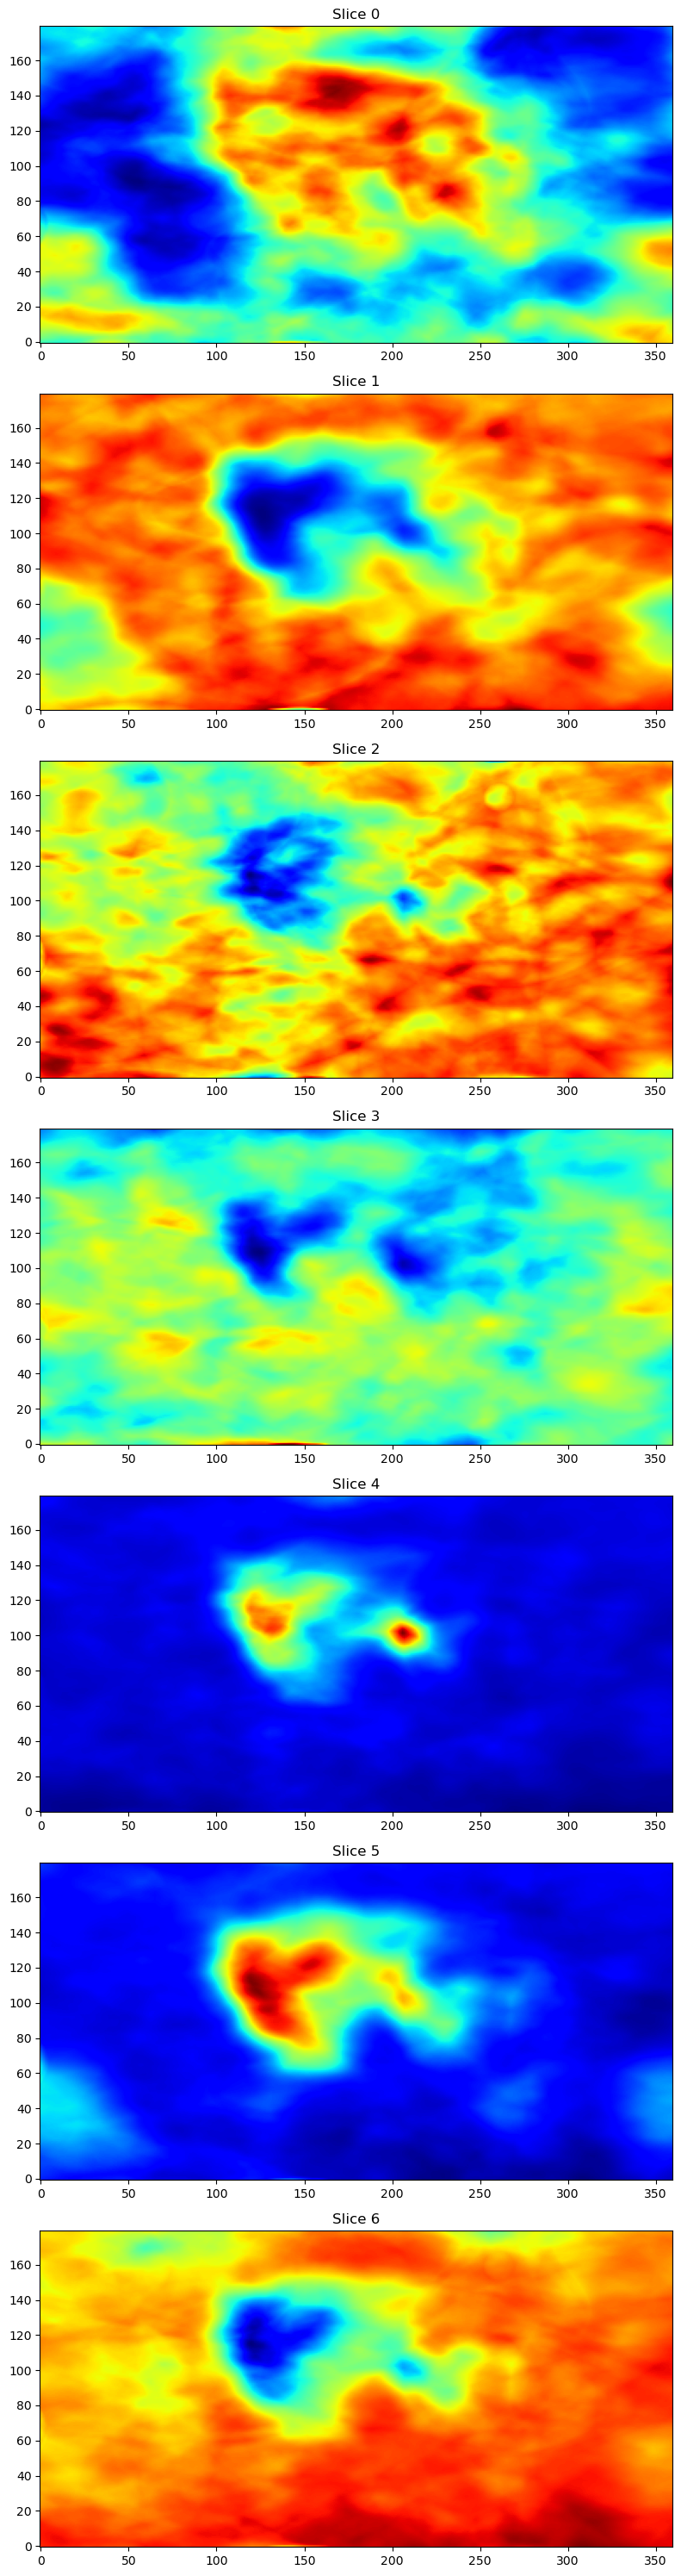

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 30))

# Plot each slice with nipy_spectral colormap
for i in range(7):
    plt.subplot(7, 1, i + 1)  # Create 7 subplots
    plt.imshow(map[:,:,i], origin="lower", cmap='jet')
    plt.title(f"Slice {i}")  # Optional: title for each subplot

plt.tight_layout()  # To prevent overlap of subplots
plt.show()


In [6]:
lat = np.arange(-90, 90, 1)
lon = np.arange(-180, 180, 1)
lat, lon = np.meshgrid(lat, lon)

vals = np.zeros((*lon.shape, 6))

In [7]:
import pandas as pd

df = pd.read_csv("./position_wt_proc.csv")

In [ ]:
for _, row in tqdm(df.iterrows()):
    # Create boolean masks for lat and lon within bounds
    lat_mask = (lat >= row["minlat"]) & (lat <= row["maxlat"])
    lon_mask = (lon >= row["minlon"]) & (lon <= row["maxlon"])

    # Combine masks to get the valid region
    mask = lat_mask & lon_mask

    # Update the vals array in the masked region
    vals[mask, 0] = row["wmgo"]
    vals[mask, 1] = row["wal2o3"]
    vals[mask, 2] = row["wsio2"]
    vals[mask, 3] = row["wcao"]
    vals[mask, 4] = row["wtio2"]
    vals[mask, 5] = row["wfeo"]

0it [00:00, ?it/s]

11306it [00:19, 572.94it/s]


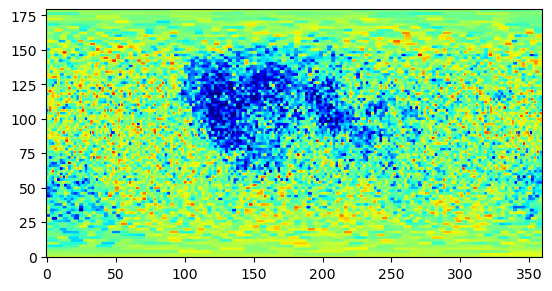

In [40]:
plt.imshow(vals[:, :, 1].T, origin="lower", cmap="jet")